torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
the predicted label is African with confidence 61.71% where the true label is African
An exception occurred in CAM with block: <class 'numpy.AxisError'>. Message: axis 2 is out of bounds for array of dimension 2


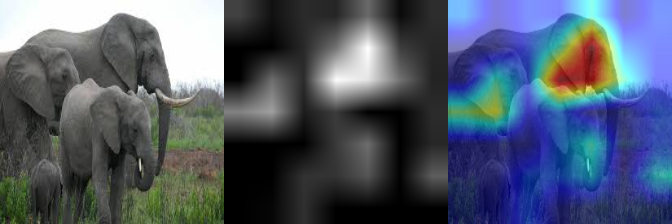

In [61]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import ImageFile

# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
# # model.eval()
# model = models.mobilenet_v3_small(weights='DEFAULT')
# num_ftrs = model.classifier[3].in_features       # 1024
# model.classifier[3] = nn.Linear(num_ftrs, 2)
model = models.resnet50(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
# model.load_state_dict(torch.load(r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\models\model_MN_v3_s_bz_32_ep_20_fe.pth'))
model.load_state_dict(torch.load(r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\checkpoints_Kornia\model_RN50_bz_128_ep_20_fe.pth'))
model.eval()

# image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
# img = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_path = r"C:\Users\Data_Science\Documents\GitHub\deep-learn-project\input\dataset\test\African\af_te19.jpg"
# image_path = r"C:\Users\Data_Science\Documents\GitHub\deep-learn-project\input\dataset\test\Asian\as_te23.jpg"
true_label = image_path.split("\\")[-2]

if true_label == "African":
    true_label_id = 0
else:
    true_label_id = 1

img = np.array(Image.open(image_path))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

print(input_tensor.shape)
print(input_tensor.size())

# predict the image class
output = model(input_tensor)
output = F.softmax(output, dim=1)
predicted_label_id = np.argmax(output.data.numpy())
if predicted_label_id == 0:
    predicted_label = "African"
    confidence = output.data.numpy()[0][0]*100
else:
    predicted_label = "Asian"
    confidence = output.data.numpy()[0][1]*100
print(f"the predicted label is {predicted_label} with confidence {confidence:.2f}% where the true label is {true_label}")

      
# The target for the CAM is the Elephant category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(predicted_label_id)] 
# target_layers = [model.layer4]

# target_layers are all the features and avgpool layers
target_layers = [model.conv1, model.bn1, model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool, model.fc]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase percent: 1.7829358577728271
The visualization of the pertubated image for the metric:


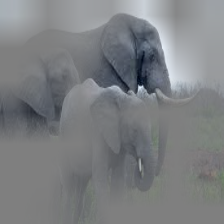

In [62]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(predicted_label_id)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [63]:
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence
print("Drop in confidence", DropInConfidence()(input_tensor, grayscale_cams, targets, model))
print("Increase in confidence", IncreaseInConfidence()(input_tensor, grayscale_cams, targets, model))

Drop in confidence [0.]
Increase in confidence [1.]


The confidence increase percent: 0.015501618385314941
The visualization of the pertubated image for the metric:


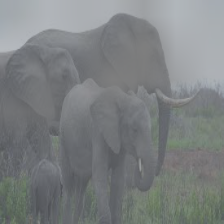

In [64]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.10177993774414062
The visualization of the pertubated image for the metric:


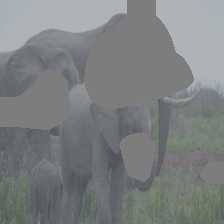

In [65]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.14685708284378052
The visualization of the pertubated image for the metric:


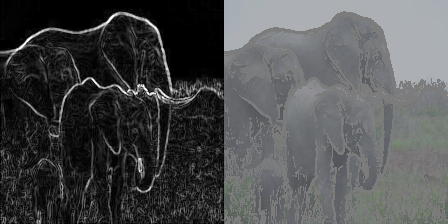

In [66]:
from pytorch_grad_cam.sobel_cam import sobel_cam

sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
sobel_cam_rgb = cv2.merge([sobel_cam_grayscale, sobel_cam_grayscale, sobel_cam_grayscale])
Image.fromarray(np.hstack((sobel_cam_rgb, visualization)))

The confidence increase when removing 25% of the image: -0.05138552188873291
The confidence increase when removing 10% of the image: -0.07240265607833862
The visualizations:


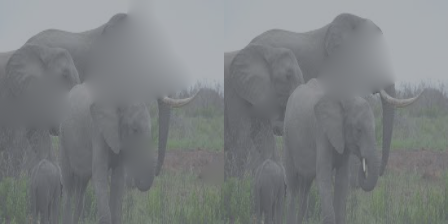

In [67]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization_10 = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization_10 = deprocess_image(visualization_10)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
Image.fromarray(np.hstack((visualization, visualization_10)))

In [68]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage
cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)
print(f"The average confidence increase with ROAD accross 4 thresholds: {scores[0]}")
scores = cam_metric(input_tensor, [sobel_cam_grayscale], targets, model)
print(f"The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: {scores[0]}")

The average confidence increase with ROAD accross 4 thresholds: -0.07374443113803864
The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: -0.1415131688117981


In [69]:
cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
print(f"Empty CAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")

Empty CAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: 0.009446561336517334


In [70]:
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
cam_metric = ROADLeastRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
print(f"Empty CAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")

Empty CAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: 0.012515589594841003


In [71]:
from pytorch_grad_cam.metrics.road import ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
print(f"Empty CAM, Combined metric avg confidence increase with ROAD accross 4 thresholds (positive is better): {scores[0]}")

Empty CAM, Combined metric avg confidence increase with ROAD accross 4 thresholds (positive is better): 0.0018877983093261719


100%|██████████| 64/64 [00:03<00:00, 16.12it/s]


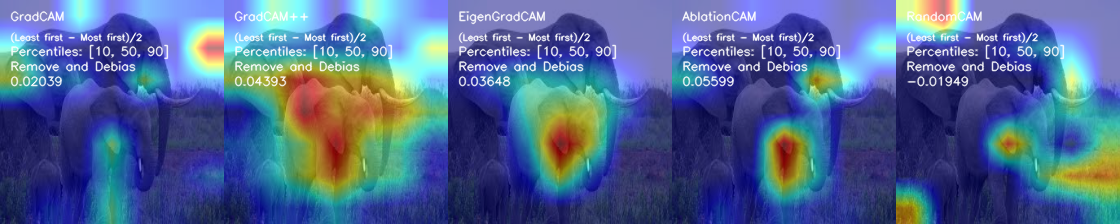

In [76]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=0):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

# cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
# cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# target_layers = [model.features, model.avgpool]
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=predicted_label_id)

100%|██████████| 64/64 [00:05<00:00, 10.98it/s]


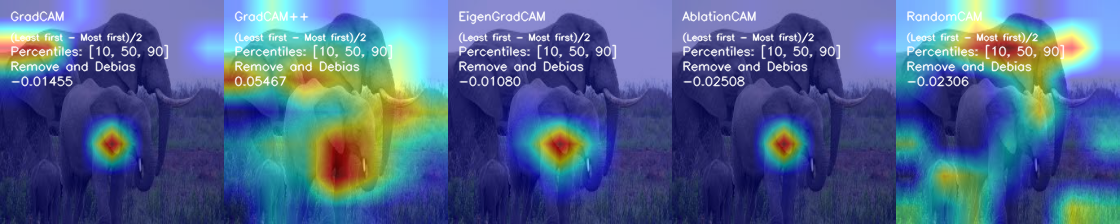

In [77]:
# target_layers = [model.layer4[-2]]
target_layers = [model.layer4[-2]]
benchmark(input_tensor, target_layers, category=predicted_label_id)

100%|██████████| 64/64 [00:07<00:00,  8.65it/s]


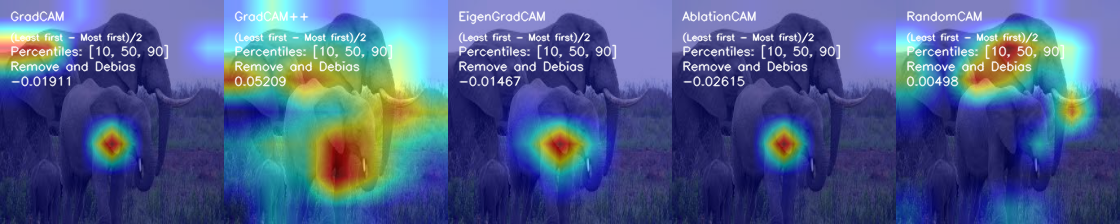

In [78]:
np.random.seed(0)
benchmark(input_tensor, target_layers, category=predicted_label_id)

100%|██████████| 64/64 [00:08<00:00,  7.67it/s]


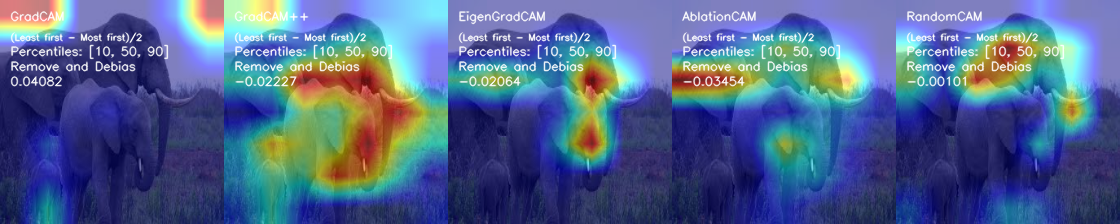

In [79]:
# Let's look how it looks for category that the model is much less confident about
np.random.seed(0)
benchmark(input_tensor, target_layers, category = 1 - predicted_label_id)